## Import the dependencies

In [47]:
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F 
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from torchvision.ops import Conv2dNormActivation

from dataclasses import dataclass
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sn

import matplotlib.pyplot as plt
import time
import numpy as np
import random
import warnings
import os
from tqdm import tqdm

import pandas as pd

warnings.filterwarnings("ignore")

In [7]:
def set_seed():
    SEED_NUMBER = 42

    random.seed(SEED_NUMBER)
    np.random.seed(SEED_NUMBER)
    torch.manual_seed(SEED_NUMBER)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_NUMBER)
        torch.cuda.manual_seed_all(SEED_NUMBER)

        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

set_seed()

In [32]:
!nvidia-smi

Thu Mar 20 13:37:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.76                 Driver Version: 560.76         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 Laptop GPU  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8              6W /   35W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [41]:
torch.cuda.device_count(), torch.cuda.current_device(), torch.cuda.get_device_name(),os.cpu_count()

(1, 0, 'NVIDIA RTX A2000 Laptop GPU', 16)

## Download and Extract the Dataset

In [9]:
# Didn't work in vscode, so downloaded it by clicking on the link
#  "https://www.dropbox.com/s/45jdd8padeyjq6t/10_Monkey_Species.zip?dl=1" -O "10_Monkey_Species.zip"

In [11]:
@dataclass
class TrainingConfig:
    batch_size = 32
    num_epochs = 50
    learning_rate = 1e-4

    log_interval = 1
    test_interval = 1
    data_root = "./"
    num_workers = 5
    device = "cuda"

train_config = TrainingConfig()
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print("Available Device: ", DEVICE)

Available Device:  cuda


In [12]:
train_root = r"10_Monkey_Species/training/training"
val_root = r"10_Monkey_Species/validation/validation/"
labels_path = r"10_Monkey_Species/monkey_labels.txt"

In [18]:
df = pd.read_csv(labels_path, header = 0)
df.columns = ['Label', 'LatinName', 'CommonName', 'TrainImages', 'ValImages']
df['LatinName'] = df['LatinName'].str.replace("\t", "")
df.head()

,Label,LatinName,CommonName,TrainImages,ValImages
0,n0,alouatta_palliata,mantled_howler,131,26
1,n1,erythrocebus_patas,patas_monkey,139,28
2,n2,cacajao_calvus,bald_uakari,137,27
3,n3,macaca_fuscata,japanese_macaque,152,30
4,n4,cebuella_pygmea,pygmy_marmoset,131,26


In [16]:
df['  Latin Name           ']

0        alouatta_palliata\t 
1       erythrocebus_patas\t 
2       cacajao_calvus\t     
3       macaca_fuscata\t     
4      cebuella_pygmea\t     
5      cebus_capucinus\t     
6      mico_argentatus\t     
7     saimiri_sciureus\t     
8      aotus_nigriceps\t     
9      trachypithecus_johnii 
Name:   Latin Name           , dtype: object

## Preprocess

In [19]:
img_size = (224, 224)

preprocess = transforms.Compose(
    [
        transforms.Resize(img_size, antialias=True),
        transforms.ToTensor()
    ]
)

## Date loader preperation

Pytorch has a inbuilt functionality to load structured image folder
- structure should be 
    - root/label/*.jpg

In [29]:
def get_mean_std(dataloader):
    batch_mean = torch.zeros(3)
    batch_mean_sqrd = torch.zeros(3)

    for batch_data, _ in dataloader:
        batch_mean += batch_data.mean(dim=(0,2,3))
        batch_mean_sqrd += (batch_data**2).mean(dim=(0,2,3))

    mean = batch_mean/(len(dataloader))
    var = (batch_mean_sqrd/ len(dataloader)) - (mean**2)
    std = var**0.5
    return mean, std

data_to_cal_mean = datasets.ImageFolder(root= train_root, transform= preprocess)
mean_train_data_loader = DataLoader(data_to_cal_mean, batch_size= train_config.batch_size)
mean, std = get_mean_std(mean_train_data_loader) 

In [30]:
mean, std

(tensor([0.4352, 0.4327, 0.3287]), tensor([0.2461, 0.2414, 0.2447]))

In [21]:
common_transforms = transforms.Compose(
    [
        preprocess,
        transforms.Normalize(mean=[0.4368, 0.4336, 0.3294], # brightness variation
                              std=[0.2457, 0.2413, 0.2447]) # contrast variation
                              # values are from monkey dataset as per the genius satya malik
    ]
)

In [23]:
# Data augumentation
train_transforms = transforms.Compose(
    [
        preprocess, 
        transforms.RandomHorizontalFlip(),
        transforms.RandomErasing(p=0.4), # zones out on a random portion of the image, in different sizes! 
        transforms.RandomApply(
            [ transforms.RandomAffine(
                                    degrees=(30,70),
                                    translate=(0.1, 0.3),
                                    scale = (0.5, 0.75))
            ], p=0.1
        ),
        transforms.Normalize(mean=[0.4368, 0.4336, 0.3294], # brightness variation
                              std=[0.2457, 0.2413, 0.2447])# contrast variation
    ]
)

### Loading train and Val dataset using ImageFolder

In [25]:
train_data = datasets.ImageFolder(root= train_root, transform= train_transforms)
val_data = datasets.ImageFolder(root=val_root, transform= common_transforms)
train_data.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [26]:
train_data.class_to_idx

{'n0': 0,
 'n1': 1,
 'n2': 2,
 'n3': 3,
 'n4': 4,
 'n5': 5,
 'n6': 6,
 'n7': 7,
 'n8': 8,
 'n9': 9}

In [31]:
train_loader = DataLoader(
    train_data,
    shuffle= True,
    batch_size= train_config.batch_size,
    num_workers= train_config.num_workers
)

val_loader = DataLoader(
    val_data,
    shuffle= False,
    batch_size= train_config.batch_size,
    num_workers= train_config.num_workers
)

In [89]:
monkey_name = df["CommonName"].to_numpy()
class_mapping = {
    idx : name.replace(" ", "") for idx, name in enumerate(monkey_name)
}
class_mapping

{0: 'mantled_howler',
 1: 'patas_monkey',
 2: 'bald_uakari',
 3: 'japanese_macaque',
 4: 'pygmy_marmoset',
 5: 'white_headed_capuchin',
 6: 'silvery_marmoset',
 7: 'common_squirrel_monkey',
 8: 'black_headed_night_monkey',
 9: 'nilgiri_langur'}

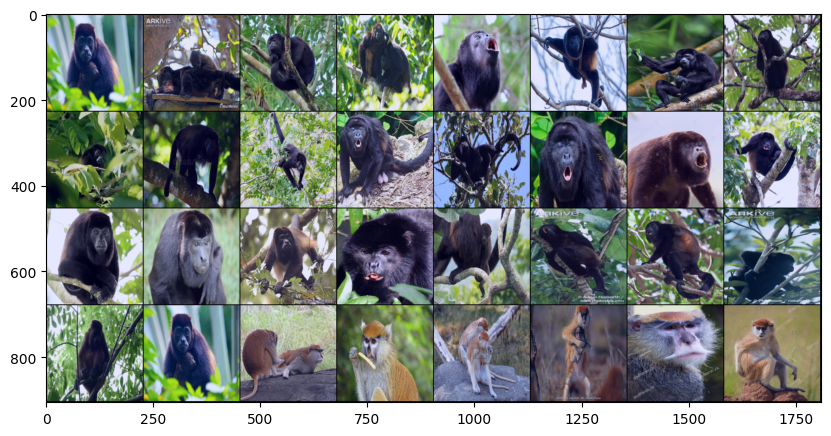

In [46]:
images, labels = next(iter(val_loader))
disp = torchvision.utils.make_grid(images, normalize= True)
fig = plt.figure(figsize=(10,10))
plt.imshow(disp.permute(1,2,0))

## Model

In [60]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()   

        self.model = nn.Sequential(
            # old way of defining
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size= 2),

            # another way of defining
            nn.LazyConv2d(out_channels=64 , kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace= True),

            nn.LazyConv2d(out_channels=128 , kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace= True),
            nn.MaxPool2d(kernel_size= 2),

            # 3rd way of defining
            Conv2dNormActivation(in_channels=128, out_channels=256, kernel_size=3),

            Conv2dNormActivation(in_channels=256, out_channels=256, kernel_size=3),
            nn.MaxPool2d(kernel_size= 2),

            Conv2dNormActivation(in_channels=256, out_channels=512, kernel_size=3),
            nn.MaxPool2d(kernel_size= 2),

            # feed forward layers
            nn.AdaptiveAvgPool2d(output_size=(3,3)),
            nn.Flatten(),

            # classification head
            nn.Linear(in_features= 512*3*3, out_features= 256),
            nn.Linear(in_features=256, out_features= 10)
        )

    
    def forward(self, x):
        return self.model(x)

In [61]:
cnn = MyModel()

optimizer = Adam(cnn.parameters(), lr = train_config.learning_rate)
DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"

log_dir = "runs/80epochs-3.3M_param_dropout"

writer = SummaryWriter(log_dir)

dummy_input = (1,3,224,224)
print(summary(cnn, dummy_input, row_settings=["var_names"], device="cpu" ))


Layer (type (var_name))                  Output Shape              Param #
MyModel (MyModel)                        [1, 10]                   --
├─Sequential (model)                     [1, 10]                   --
│    └─Conv2d (0)                        [1, 32, 220, 220]         2,432
│    └─BatchNorm2d (1)                   [1, 32, 220, 220]         64
│    └─ReLU (2)                          [1, 32, 220, 220]         --
│    └─Conv2d (3)                        [1, 32, 218, 218]         9,248
│    └─BatchNorm2d (4)                   [1, 32, 218, 218]         64
│    └─ReLU (5)                          [1, 32, 218, 218]         --
│    └─MaxPool2d (6)                     [1, 32, 109, 109]         --
│    └─Conv2d (7)                        [1, 64, 107, 107]         18,496
│    └─BatchNorm2d (8)                   [1, 64, 107, 107]         128
│    └─ReLU (9)                          [1, 64, 107, 107]         --
│    └─Conv2d (10)                       [1, 128, 105, 105]        73,856


## Model training and Evaluation

In [ ]:
def train(model, train_loader):
    model.train()
    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_train_samples = 0

    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)

        loss = F.cross_entropy(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        value, predicted_index = torch.max(outputs.data, dim= 1)
        total_train_samples += labels.shape[0]
        correct_predictions += (predicted_index == labels).sum().item()

    train_avg_loss = running_loss/len(train_loader)
    train_accuracy = 100 * correct_predictions/ total_train_samples
    return train_avg_loss, train_accuracy

In [75]:
def validation(model, val_loader):
    model.eval()
    model.to(DEVICE)

    running_loss = 0
    correct_predictions = 0
    total_val_samples = 0

    for images, labels in tqdm(val_loader, desc="Validation"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
    
        with torch.no_grad():
            outputs = model(images)

        loss = F.cross_entropy(outputs, labels)
        running_loss += loss.item()
        value, predicted_index = torch.max(outputs.data, dim= 1)
        total_val_samples += labels.shape[0]
        correct_predictions += (predicted_index == labels).sum().item()

    val_avg_loss = running_loss/len(val_loader)
    val_accuracy = 100 * correct_predictions/ total_val_samples
    return val_avg_loss, val_accuracy


In [76]:
def main(model, train_loader, val_loader):

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_acc = 0
    best_weights = None

    for epoch in range(train_config.num_epochs):
        train_loss, train_accuracy = train(model, train_loader)
        val_loss, val_accuracy = validation(model, val_loader)

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1:0>2}/{train_config.num_epochs} - Trainloss:{train_loss:.3f} - Valloss:{val_loss:.3f} - TrainAcc:{train_accuracy:.3f} - ValAcc:{val_accuracy:.3f}  ")

        writer.add_scalar("Loss/train:", train_loss)
        writer.add_scalar("Loss/val:", val_loss)
        writer.add_scalar("Accuracy/train:", train_accuracy)
        writer.add_scalar("Accuracy/val:", val_accuracy)

        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_weights = model.state_dict()
            print(f"Saving the model!!!")
            torch.save(best_weights, "best.pt")
        

    return train_losses, train_accuracies, val_losses, val_accuracies


In [77]:
train_losses, train_accuracies, val_losses, val_accuracies = main(cnn, train_loader, val_loader)

Validation: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s]


Epoch 01/50 - Trainloss:0.242 - Valloss:0.953 - TrainAcc:92.799 - ValAcc:76.838  
Saving the model!!!


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


Epoch 02/50 - Trainloss:0.206 - Valloss:0.805 - TrainAcc:93.163 - ValAcc:76.838  


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


Epoch 03/50 - Trainloss:0.255 - Valloss:0.782 - TrainAcc:92.160 - ValAcc:79.779  
Saving the model!!!


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.22it/s]


Epoch 04/50 - Trainloss:0.274 - Valloss:0.852 - TrainAcc:90.884 - ValAcc:77.206  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


Epoch 05/50 - Trainloss:0.249 - Valloss:0.742 - TrainAcc:91.613 - ValAcc:81.250  
Saving the model!!!


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 06/50 - Trainloss:0.237 - Valloss:0.988 - TrainAcc:92.434 - ValAcc:75.735  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 07/50 - Trainloss:0.276 - Valloss:0.793 - TrainAcc:90.611 - ValAcc:78.676  


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


Epoch 08/50 - Trainloss:0.225 - Valloss:0.859 - TrainAcc:92.525 - ValAcc:79.044  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 09/50 - Trainloss:0.212 - Valloss:0.852 - TrainAcc:93.984 - ValAcc:82.353  
Saving the model!!!


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 10/50 - Trainloss:0.210 - Valloss:0.743 - TrainAcc:93.892 - ValAcc:80.515  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 11/50 - Trainloss:0.259 - Valloss:0.915 - TrainAcc:91.340 - ValAcc:79.412  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 12/50 - Trainloss:0.238 - Valloss:0.891 - TrainAcc:93.254 - ValAcc:77.206  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 13/50 - Trainloss:0.211 - Valloss:0.978 - TrainAcc:92.707 - ValAcc:77.206  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


Epoch 14/50 - Trainloss:0.180 - Valloss:0.796 - TrainAcc:94.439 - ValAcc:82.353  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Epoch 15/50 - Trainloss:0.187 - Valloss:0.821 - TrainAcc:93.801 - ValAcc:78.309  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 16/50 - Trainloss:0.184 - Valloss:0.930 - TrainAcc:94.166 - ValAcc:78.676  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Epoch 17/50 - Trainloss:0.201 - Valloss:1.016 - TrainAcc:93.619 - ValAcc:77.206  


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


Epoch 18/50 - Trainloss:0.302 - Valloss:1.086 - TrainAcc:90.428 - ValAcc:77.574  


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


Epoch 19/50 - Trainloss:0.254 - Valloss:0.899 - TrainAcc:92.160 - ValAcc:77.574  


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


Epoch 20/50 - Trainloss:0.208 - Valloss:0.718 - TrainAcc:93.619 - ValAcc:81.985  


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


Epoch 21/50 - Trainloss:0.213 - Valloss:0.703 - TrainAcc:93.254 - ValAcc:83.456  
Saving the model!!!


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


Epoch 22/50 - Trainloss:0.135 - Valloss:0.805 - TrainAcc:95.624 - ValAcc:80.882  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 23/50 - Trainloss:0.182 - Valloss:0.907 - TrainAcc:94.531 - ValAcc:78.309  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


Epoch 24/50 - Trainloss:0.232 - Valloss:1.010 - TrainAcc:92.616 - ValAcc:77.574  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 25/50 - Trainloss:0.187 - Valloss:0.961 - TrainAcc:93.528 - ValAcc:79.779  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 26/50 - Trainloss:0.190 - Valloss:0.899 - TrainAcc:93.984 - ValAcc:79.779  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Epoch 27/50 - Trainloss:0.136 - Valloss:0.735 - TrainAcc:95.260 - ValAcc:83.088  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 28/50 - Trainloss:0.130 - Valloss:0.857 - TrainAcc:95.716 - ValAcc:79.779  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


Epoch 29/50 - Trainloss:0.158 - Valloss:0.811 - TrainAcc:95.260 - ValAcc:80.882  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.35it/s]


Epoch 30/50 - Trainloss:0.170 - Valloss:0.716 - TrainAcc:94.348 - ValAcc:80.515  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 31/50 - Trainloss:0.144 - Valloss:0.709 - TrainAcc:95.716 - ValAcc:84.559  
Saving the model!!!


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 32/50 - Trainloss:0.157 - Valloss:0.954 - TrainAcc:94.713 - ValAcc:77.574  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Epoch 33/50 - Trainloss:0.166 - Valloss:0.955 - TrainAcc:95.169 - ValAcc:80.515  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


Epoch 34/50 - Trainloss:0.193 - Valloss:0.678 - TrainAcc:94.348 - ValAcc:83.824  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Epoch 35/50 - Trainloss:0.191 - Valloss:0.923 - TrainAcc:93.892 - ValAcc:79.044  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


Epoch 36/50 - Trainloss:0.167 - Valloss:0.812 - TrainAcc:94.986 - ValAcc:80.147  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 37/50 - Trainloss:0.163 - Valloss:0.861 - TrainAcc:94.713 - ValAcc:79.412  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 38/50 - Trainloss:0.202 - Valloss:0.947 - TrainAcc:93.984 - ValAcc:80.147  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 39/50 - Trainloss:0.301 - Valloss:1.128 - TrainAcc:89.517 - ValAcc:77.574  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 40/50 - Trainloss:0.190 - Valloss:0.746 - TrainAcc:93.163 - ValAcc:82.353  


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


Epoch 41/50 - Trainloss:0.202 - Valloss:0.896 - TrainAcc:93.254 - ValAcc:81.618  


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


Epoch 42/50 - Trainloss:0.139 - Valloss:0.723 - TrainAcc:95.169 - ValAcc:84.926  
Saving the model!!!


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.23it/s]


Epoch 43/50 - Trainloss:0.127 - Valloss:0.714 - TrainAcc:95.989 - ValAcc:84.191  


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.24it/s]


Epoch 44/50 - Trainloss:0.152 - Valloss:0.947 - TrainAcc:94.804 - ValAcc:79.044  


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


Epoch 45/50 - Trainloss:0.156 - Valloss:0.743 - TrainAcc:94.895 - ValAcc:84.191  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


Epoch 46/50 - Trainloss:0.176 - Valloss:0.964 - TrainAcc:93.801 - ValAcc:77.574  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


Epoch 47/50 - Trainloss:0.176 - Valloss:1.090 - TrainAcc:95.260 - ValAcc:77.941  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.32it/s]


Epoch 48/50 - Trainloss:0.212 - Valloss:1.050 - TrainAcc:92.616 - ValAcc:78.309  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


Epoch 49/50 - Trainloss:0.181 - Valloss:0.998 - TrainAcc:94.531 - ValAcc:79.044  


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]

Epoch 50/50 - Trainloss:0.146 - Valloss:0.789 - TrainAcc:94.895 - ValAcc:82.353  


## Metrics

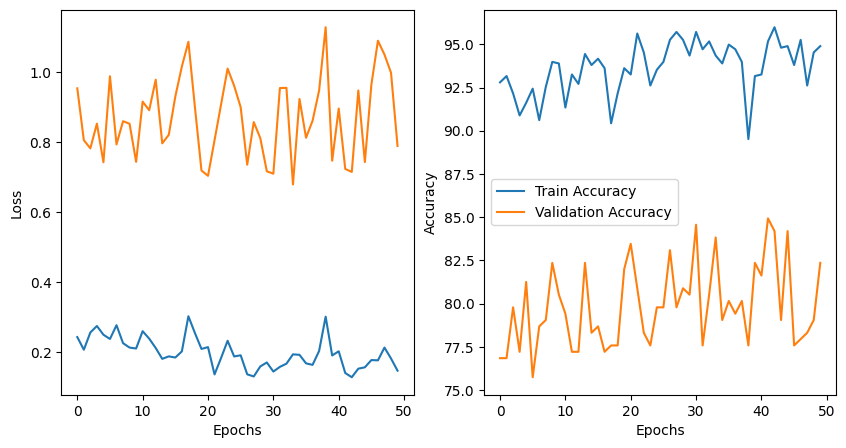

In [78]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")  
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show() 


## Loading saved model

In [79]:
cnn.load_state_dict(torch.load("best.pt"))
cnn.eval()

MyModel(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2dNormActivation(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 

In [80]:
def prediction(model, loader):
    model.eval()
    model.to(DEVICE)

    all_preds, all_pred_prob = [], []
    all_images, all_labels = [], []

    for images, labels in tqdm(loader, desc="Predicting"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        with torch.inference_mode():
            outputs = model(images)

        prob = F.softmax(outputs, dim=1)
        pred_prob, predicted_index = torch.max(prob, dim=1)

        all_images.append(images.cpu())
        all_labels.append(labels.cpu())
        all_preds.append(predicted_index.cpu())
        all_pred_prob.append(pred_prob.cpu())

    return (
        torch.cat(all_images).numpy(),
        torch.cat(all_labels).numpy(),
        torch.cat(all_preds).numpy(),
        torch.cat(all_pred_prob).numpy()
    )

## Prediction with images form loader 

In [90]:
def denormalize(image):
    # mean and std deviation of the dataset
    image = image * np.array(std) + np.array(mean)
    return np.clip(image, 0, 1)

def visualize_predictions(sample_images, sample_gt_labels, pred_indicies, pred_prob, num_images = 5):
    fig = plt.figure(figsize=(20, 5))

    for i in range(num_images):
        idx = random.randint(0, len(sample_images)-1)
        image = sample_images[idx].transpose(1,2,0)
        label = sample_gt_labels[idx]
        pred_label = pred_indicies[idx]
        prob = pred_prob[idx]

        image = denormalize(image)

        ax = fig.add_subplot(1, num_images, i+1)
        ax.imshow(image)
        ax.set_title(f"GT: {class_mapping[label]}\nPred: {class_mapping[pred_label]} - {prob:.2f}")
        ax.axis("off")

    plt.show()

In [91]:
val_images, val_gt_labels, val_preds, val_pred_prob = prediction(cnn, val_loader)



Predicting: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


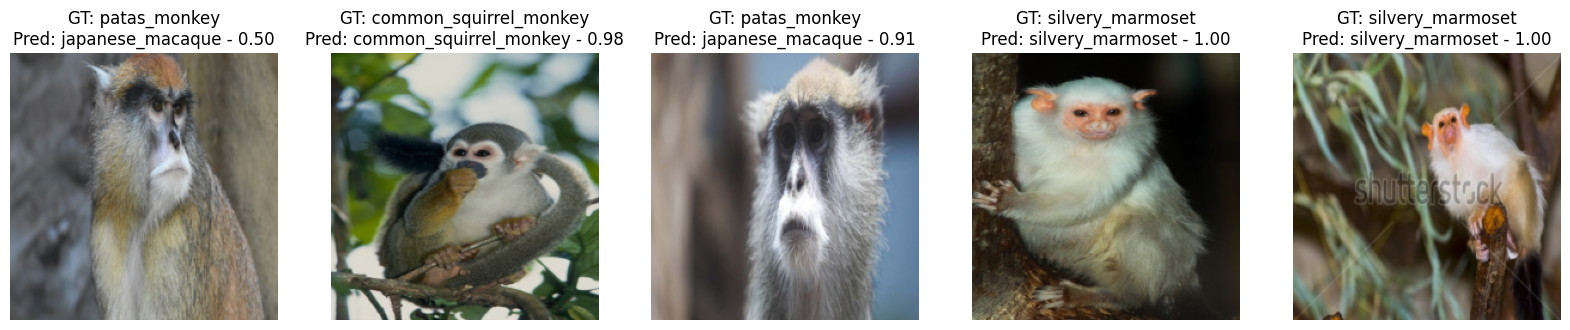

In [96]:
visualize_predictions(val_images, val_gt_labels, val_preds, val_pred_prob, num_images=5)

## Confusion matrix

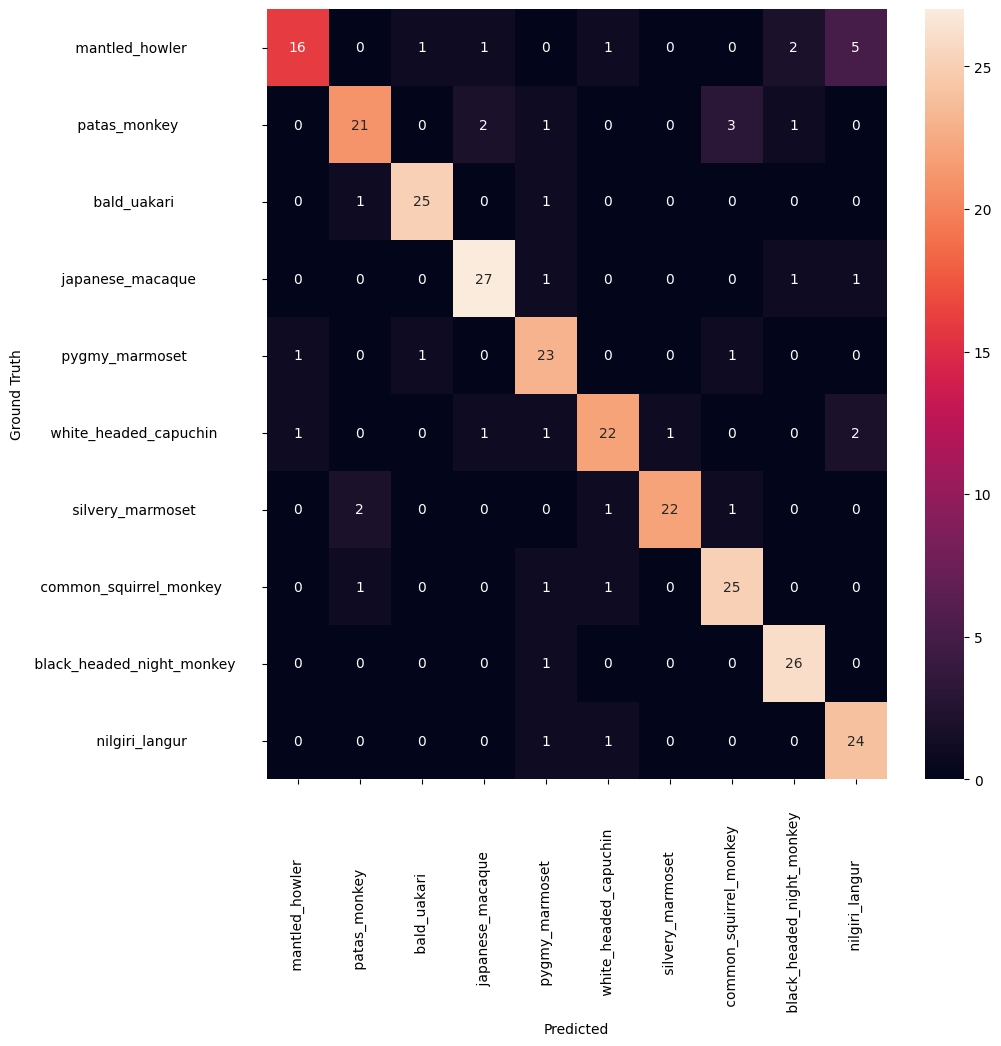

In [93]:
cm = confusion_matrix(val_gt_labels, val_preds)
plt.figure(figsize=(10,10))
sn.heatmap(cm, annot=True, fmt="d", xticklabels=monkey_name, yticklabels=monkey_name)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.show()